# 01 — CNN Feature Extraction (ResNet50)

This notebook implements the **feature extraction stage** of the project pipeline.  
Following the initial **Exploratory Data Analysis (EDA)**, the objective here is to transform raw images into structured numerical representations that can be effectively used by downstream machine learning algorithms.

Images are high-dimensional and unstructured by nature, making them unsuitable for most classical machine learning methods in their raw form. To address this, we employ **Convolutional Neural Networks (CNNs)**, which are specifically designed to learn hierarchical and spatial features from image data.

Rather than training a neural network from scratch, we leverage a **pre-trained ResNet50 model** as a fixed feature extractor. ResNet50 has been trained on large-scale image datasets and is able to capture rich and transferable visual representations. This approach ensures strong performance while remaining computationally efficient and reproducible.

The main goal of this notebook is to **process all images in the `patternmind_dataset/` directory and convert each image into a fixed-length feature vector**. These vectors represent high-level image features and provide a common embedding space for comparison and analysis.

At the end of the execution, the following artifacts are generated and saved to disk:
- `X_features.npy`: matrix of extracted feature vectors,
- `y_labels.npy`: numerical labels associated with each image,
- `label_names.npy`: mapping between label indices and semantic class names.

These outputs are used as inputs for the **subsequent clustering notebooks**, where different unsupervised learning techniques (K-Means, Hierarchical Clustering, and DBSCAN) are applied to analyze the structure of the dataset.

> **Execution order**  
> This notebook must be run **after the EDA notebook** and **before any clustering notebook**, as it provides the feature representations required for all downstream analyses.


## 1. Imports

In this section, we import all the libraries required for **data handling, image processing, feature extraction, and basic validation**.

Specifically:
- **Filesystem utilities** are used to navigate directories and manage image paths.
- **Image processing and visualization tools** handle image loading and inspection.
- **Numerical computing libraries** support array manipulation and efficient storage of extracted features.
- **Deep learning utilities** from `tensorflow.keras` are used to load a pre-trained ResNet50 model and apply the appropriate preprocessing pipeline.
- **Machine learning utilities** provide simple checks to validate the extracted feature representations.

These imports define the core dependencies for the feature extraction pipeline implemented in this notebook.


In [6]:
from google.colab import drive

import os
import glob
from pathlib import Path

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 2. Mount Drive and Locate the Dataset

This section handles **data access and dataset initialization**.

The project assumes that the dataset is stored as a compressed archive (`.zip`) on Google Drive. We first mount Google Drive to the Colab environment and then extract the dataset into a local working directory. If the dataset has already been extracted in a previous run, the existing directory is reused to avoid unnecessary duplication.

The variable `DATA_ROOT` is defined as the main entry point to the dataset and is used throughout the remainder of the notebook to locate image files in a consistent and reproducible manner.

  
> If you are running this notebook outside of Google Colab, this section can be adapted by directly setting `DATA_ROOT` to the local path where the dataset is stored.


In [7]:
drive.mount('/content/drive')

ZIP_PATH = "/content/drive/MyDrive/patternmind_dataset.zip"
UNZIP_DIR = "/content/patternmind_unzipped"

!mkdir -p "{UNZIP_DIR}"
!unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/patternmind_unzipped/__MACOSX/._patternmind_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
DATASET_DIR_NAME = "patternmind_dataset"   # the folder inside the zip

DATA_ROOT = os.path.join(UNZIP_DIR, DATASET_DIR_NAME)
print("Will use DATA_ROOT:", DATA_ROOT)


if not os.path.isdir(DATA_ROOT):
    os.makedirs(UNZIP_DIR, exist_ok=True)
    !unzip -q "{ZIP_PATH}" -d "{UNZIP_DIR}"
    print("Unzipped dataset.")
else:
    print("Dataset already unzipped.")


Will use DATA_ROOT: /content/patternmind_unzipped/patternmind_dataset
Dataset already unzipped.


## 3. Collect Image Paths (Sanity Check)

Before initializing any data generators or performing feature extraction, we explicitly collect **all image file paths** contained in `DATA_ROOT`. This step acts as a **sanity check** to verify that the dataset has been correctly located and that all expected image files are accessible.

Image paths are retrieved recursively using `glob`, considering the most common image formats supported by Keras:
- `.jpg`
- `.jpeg`
- `.png`

Performing this explicit scan allows us to:
- confirm the total number of available images,
- identify potential issues such as missing, duplicated, or misplaced files,
- ensure consistency between the dataset structure and subsequent processing steps.

The resulting list of image paths is saved as `image_paths.npy`. Persisting this artifact improves **reproducibility** and allows downstream stages of the pipeline to operate on a fixed and validated set of inputs without repeatedly scanning the filesystem.

In [9]:
extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []
for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(DATA_ROOT, '**', ext), recursive=True))

print(f'Found {len(image_paths)} images.')
image_paths[:5]

Found 25557 images.


['/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_16.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_78.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_18.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_24.jpg',
 '/content/patternmind_unzipped/patternmind_dataset/microscope/microscope_50.jpg']

In [10]:
np.save("/content/image_paths.npy", np.array(image_paths))
print("Saved image_paths.npy")

Saved image_paths.npy


## 4. Load Images with ImageDataGenerator

In this section, we load images from disk using Keras’ `ImageDataGenerator` and prepare them for feature extraction with the pre-trained ResNet50 model.

We use the `flow_from_directory` interface to stream images directly from `DATA_ROOT` in batches. This approach is memory-efficient and allows us to process large image datasets without loading all images into memory at once.

The generator is configured with the following design choices:
- **Target size**: images are resized to `224 × 224`, which is the input resolution expected by ResNet50.
- **Preprocessing**: ResNet50’s `preprocess_input` function is applied to ensure consistency with the model’s original training setup.
- **Labels**: numeric labels are automatically inferred from the directory structure (`class_mode='sparse'`).
- **Fixed ordering**: `shuffle=False` is explicitly set to preserve the order of images. This is critical to guarantee a correct alignment between image paths, extracted feature vectors, and labels in later stages of the pipeline.

The resulting generator yields batches of preprocessed images that are passed directly to the CNN feature extractor in the next step.


In [11]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

generator = datagen.flow_from_directory(
    DATA_ROOT,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False          # VERY IMPORTANT: keep order fixed
)

print("Total images:", generator.samples)
print("Number of classes:", generator.num_classes)
print("Class indices (folder -> label):")
print(generator.class_indices)

Found 25557 images belonging to 233 classes.
Total images: 25557
Number of classes: 233
Class indices (folder -> label):
{'airplanes': 0, 'ak47': 1, 'american-flag': 2, 'backpack': 3, 'baseball-glove': 4, 'bat': 5, 'bathtub': 6, 'bear': 7, 'billiards': 8, 'binoculars': 9, 'birdbath': 10, 'blimp': 11, 'bonsai': 12, 'boom-box': 13, 'bowling-ball': 14, 'bowling-pin': 15, 'boxing-glove': 16, 'brain': 17, 'breadmaker': 18, 'buddha': 19, 'bulldozer': 20, 'butterfly': 21, 'cactus': 22, 'cake': 23, 'calculator': 24, 'camel': 25, 'cannon': 26, 'car-side': 27, 'car-tire': 28, 'cartman': 29, 'cd': 30, 'centipede': 31, 'cereal-box': 32, 'chandelier': 33, 'chess-board': 34, 'chimp': 35, 'chopsticks': 36, 'clutter': 37, 'cockroach': 38, 'coffee-mug': 39, 'coffin': 40, 'coin': 41, 'comet': 42, 'computer-keyboard': 43, 'computer-mouse': 44, 'conch': 45, 'cormorant': 46, 'covered-wagon': 47, 'cowboy-hat': 48, 'desk-globe': 49, 'diamond-ring': 50, 'dice': 51, 'dog': 52, 'dolphin-101': 53, 'doorknob': 54

## 5. Load Pre-trained ResNet50 as a Feature Extractor

In this section, we load a **ResNet50 model pre-trained on ImageNet** and configure it as a **fixed feature extractor**.

The final classification layers are removed by setting `include_top=False`, allowing us to use the network as a generic feature encoder rather than as a classifier. To obtain a compact and consistent representation for each image, we apply **global average pooling** (`pooling='avg'`), which aggregates spatial information across feature maps.

With this configuration, each input image is mapped to a **2048-dimensional feature vector**, capturing high-level semantic information learned during pre-training.

The model is used **only for inference**, and no weights are updated during this process. This design choice ensures computational efficiency and reproducibility while leveraging powerful representations learned from large-scale visual data.

In [12]:
feature_extractor = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224, 224, 3)
)

feature_extractor.summary()  #inspecting the model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 6. Extract Feature Vectors for All Images

In this step, we pass the entire dataset through the pre-trained ResNet50 feature extractor to compute a numerical representation for each image.

Specifically, this process produces:
- **`X`**: a feature matrix of shape `(N_images, 2048)`, where each row corresponds to one image,
- **`y`**: a vector of numeric class labels aligned with the images,
- **`label_names`**: an ordered list mapping label indices to class names.

Because the image generator was initialized with `shuffle=False`, the order of images is preserved throughout the pipeline. This guarantees a correct and consistent alignment between image paths, extracted features, and labels.

The resulting feature matrix and labels constitute the final output of the feature extraction stage and will be used as input for all subsequent clustering and analysis notebooks.


In [13]:
X = feature_extractor.predict(generator, verbose=1)
y = generator.classes

label_names = list(generator.class_indices.keys())

print("Feature matrix shape X:", X.shape)
print("Labels shape y:", y.shape)
print("Number of label names:", len(label_names))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


799/799 ━━━━━━━━━━━━━━━━━━━━ 4224s 5s/step
Feature matrix shape X: (25557, 2048)
Labels shape y: (25557,)
Number of label names: 233


## 7. Save Feature Matrix and Labels

In this final step, we persist the outputs of the feature extraction pipeline to disk so they can be reused by downstream notebooks without recomputing CNN features.

The following artifacts are saved in NumPy (`.npy`) format:
- **`X_features.npy`**: the extracted feature matrix of shape `(N_images, 2048)`,
- **`y_labels.npy`**: numeric class labels aligned with the feature matrix,
- **`label_names.npy`**: mapping from label indices to semantic class names,
- **`image_paths.npy`**: the original image file paths corresponding to each feature vector.

Storing these files ensures a **clear separation between feature extraction and analysis**, improves reproducibility, and significantly reduces computational overhead for subsequent experiments.

These saved artifacts constitute the primary inputs for the clustering notebooks and any further exploratory or analytical tasks built on top of the extracted image representations.


In [14]:
np.save("/content/X_features.npy", X)
np.save("/content/y_labels.npy", y)
np.save("/content/label_names.npy", np.array(label_names))
np.save("/content/image_paths.npy", np.array(image_paths))

print("Saved: X_features.npy, y_labels.npy, label_names.npy, image_paths.npy")

Saved: X_features.npy, y_labels.npy, label_names.npy, image_paths.npy


In [15]:
!cp "/content/X_features.npy" "/content/drive/MyDrive/projectml colab/X_features.npy"
!cp "/content/y_labels.npy" "/content/drive/MyDrive/projectml colab/y_labels.npy"
!cp "/content/label_names.npy" "/content/drive/MyDrive/projectml colab/label_names.npy"


## 8. Sanity Checks on Extracted Features

Before concluding the feature extraction pipeline, we perform a set of **sanity checks** to validate the integrity and consistency of the saved outputs. These checks ensure that the extracted features, labels, and metadata are correctly aligned and suitable for downstream analysis.

### 8.1 Shape and Consistency Checks

We reload the saved arrays from disk and verify the following conditions:
- the number of feature vectors matches the number of images processed,
- the dimensionality of each feature vector is correct (2048 for ResNet50 with global average pooling),
- the number of labels matches the number of feature vectors,
- the number of unique labels is consistent with the number of class names.

Successful validation of these conditions confirms that feature extraction and serialization were executed correctly and that the resulting artifacts are safe to use in subsequent clustering and analysis notebooks.


In [16]:
# Load the saved arrays
X = np.load("/content/X_features.npy")
y = np.load("/content/y_labels.npy")
label_names = np.load("/content/label_names.npy", allow_pickle=True)

print("X shape:", X.shape)          # (25557, 2048)
print("y shape:", y.shape)          # (25557,)
print("Number of label names:", len(label_names))
print("Unique labels:", len(np.unique(y)))


X shape: (25557, 2048)
y shape: (25557,)
Number of label names: 233
Unique labels: 233


### 8.2 Missing Values

Although CNN-based feature extractors typically do not produce missing values, we explicitly check for the presence of **NaN entries** in the extracted feature matrix.

This validation step is important because downstream methods such as **PCA** or **clustering algorithms** may fail or behave unpredictably in the presence of missing values. A zero count confirms that all feature values are numerically valid and that the feature matrix is safe to use for subsequent analysis.


In [17]:
nan_count = np.isnan(X).sum()
print("Number of NaN values in X:", nan_count)

Number of NaN values in X: 0


### 8.3 Zero-variance Features

We verify whether any feature dimensions have **zero variance** across all images. Features that are constant for every sample do not carry discriminative information and can negatively affect dimensionality reduction or clustering methods.

Although ResNet50 rarely produces constant activations, performing this check ensures that the extracted feature space is informative and well-suited for unsupervised learning tasks. The absence (or minimal presence) of zero-variance features confirms the quality and usefulness of the learned representations.


In [18]:
selector = VarianceThreshold(threshold=0.0)
selector.fit(X)
num_constant_features = X.shape[1] - selector.transform(X).shape[1]
print("Number of constant (zero-variance) features:", num_constant_features)

Number of constant (zero-variance) features: 0


### 8.3 Zero-variance Features

Finally, we verify whether any feature dimensions have **zero variance** across all images. Features that are constant for every sample do not carry discriminative information and can negatively affect dimensionality reduction or clustering methods.

Although ResNet50 rarely produces constant activations, performing this check ensures that the extracted feature space is informative and well-suited for unsupervised learning tasks. The absence (or minimal presence) of zero-variance features confirms the quality and usefulness of the learned representations.


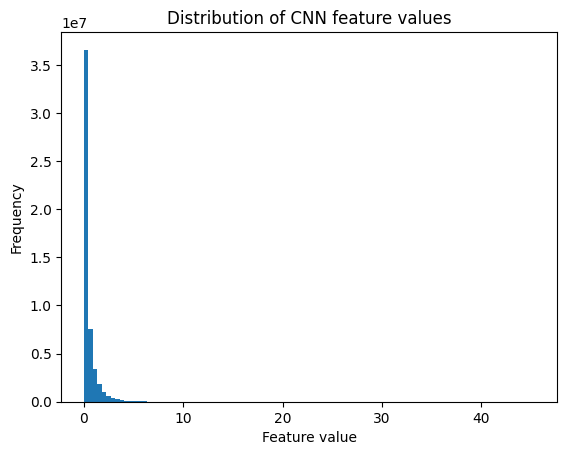

In [19]:
plt.hist(X.flatten(), bins=100)
plt.title("Distribution of CNN feature values")
plt.xlabel("Feature value")
plt.ylabel("Frequency")
plt.show()

## 9. Next Steps

After successfully running this notebook, the feature extraction pipeline is complete. The following files should now be available in the project directory:

- **`X_features.npy`** — feature matrix containing the extracted CNN representations  
- **`y_labels.npy`** — numeric class labels corresponding to each image  
- **`label_names.npy`** — mapping from label indices to semantic class names  
- **`image_paths.npy`** — original image file paths, aligned with `X` and `y`

These artifacts constitute the final output of the feature extraction stage and are designed to be reused directly by downstream analysis notebooks.

The clustering notebooks can load the extracted data as follows:

```python
X = np.load("X_features.npy")
y = np.load("y_labels.npy")
label_names = np.load("label_names.npy", allow_pickle=True)
image_paths = np.load("image_paths.npy", allow_pickle=True)
